Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline). 

In [1]:
# Import Statements
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# Dataset
from sklearn.datasets import fetch_20newsgroups
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# 2 categories to class today
categories = ['alt.atheism',
              'talk.religion.misc']

data = fetch_20newsgroups(subset='all', 
                          categories=categories)

In [3]:
len(data.data)

1427

In [4]:
X = data.data
Y = data.target

In [5]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    Parameters
    ----------
    text: string or object 
    Returns
    -------
    text: string or object
    """
    # remove emails from text
    email_regex = "\S+@\S+"
    newline_regex = "\\n"
    special_chars_regex = "[:?.,\>|!;\\']"

    text = re.sub(email_regex, "", text)
    text = re.sub(newline_regex, "", text)
    text = re.sub(special_chars_regex, "", text)
    
    return text 

In [6]:
# data set has been cleaned
X_clean = [clean_data(txt) for txt in X]

In [7]:
# prep data, instantiate a model, create pipeline object, and run a gridsearch 

# create pipeline components 
tfidf = TfidfVectorizer(stop_words='english')
rfc = RandomForestClassifier()

# define a pipeline object
pipe = Pipeline([('vect', tfidf), # data transformer
                 ('clf', rfc)])   # classifier

In [8]:
# create hyper-parameter dictionary
params = {
    'vect__max_df': (0.80, .90),
    'vect__min_df': (.05, .10), 
    'vect__max_features': (500, 1000), 
    'clf__n_estimators': (10, 100), 
    'clf__max_depth': (None, 10) 
}

# create gridsearch object
gs = GridSearchCV(pipe, params, cv=3, n_jobs=-2, verbose=1)

# fit gridseach 
gs.fit(X_clean, Y)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'clf__max_depth': (None, 10),
                         'clf__n_estimators': (10, 100),
                         'vect__max_df': (0.8, 0.9),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (0.05, 0.1)},
             verbose=1)

In [9]:
baseline_acc = Y.sum()/len(Y)
baseline_acc

0.4400840925017519

In [10]:
gs.best_score_

0.8248061329795076

In [11]:
gs.best_params_

{'clf__max_depth': None,
 'clf__n_estimators': 100,
 'vect__max_df': 0.8,
 'vect__max_features': 500,
 'vect__min_df': 0.05}

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

## Challenge

You're trying to achieve 75% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1538411402/image3_maagmh.png)

**Take Away:** LSA has 2 main benefits

1. Dimensionality Reduction
2. Topic Modeling (feature engineering) -- identifies the latent/hidden topics that are present in our doc-term matrix. This is something that counting vectorizers can't do (i.e. CountVectorizer, TFIDF)

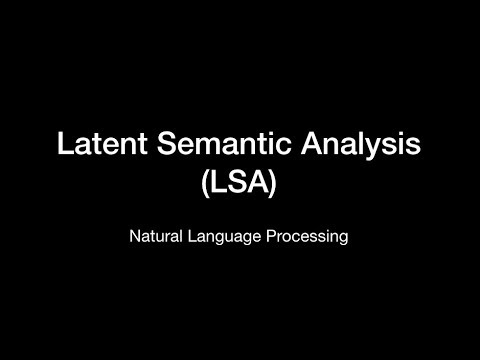

In [12]:
from IPython.display import YouTubeVideo
YouTubeVideo('OvzJiur55vo', width=1024, height=576)

### First an example

Before we apply Latent Semantic Analysis in a pipeline, let's work through a simple example together in order to better understand how LSA works and develop an intuition along the way. 

First, if you haven't already, watch the short video provided above. We will be implementing the example from the video in our notebook. 

In [13]:
# Import

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

svd = TruncatedSVD(n_components=2, # number of topics to generate (also the size of the new feature space)
                   algorithm='randomized',
                   n_iter=10)

# let's use the same data that was used in the video for consistancy 

        # topic 1 data 
data = ["pizza", 
        "hamberger", 
        "cookie", 
        "pizza hamberger cookie",
        # topic 2 data
        "ramen", 
        "sushi", 
        "ramen sushi"]

In [14]:
# CREATE Term-Frequency matrix 

tf_vect = CountVectorizer()
tfm = tf_vect.fit_transform(data)
tfm = pd.DataFrame(data=tfm.toarray(), columns = tf_vect.get_feature_names())

tfm.index = data

tfm

,cookie,hamberger,pizza,ramen,sushi
pizza,0,0,1,0,0
hamberger,0,1,0,0,0
cookie,1,0,0,0,0
pizza hamberger cookie,1,1,1,0,0
ramen,0,0,0,1,0
sushi,0,0,0,0,1
ramen sushi,0,0,0,1,1


In [15]:
# Use SVD to transform our Term-Frequency matrix into a Topic matrix with reduced dimensionality

X_reduced = svd.fit_transform(tfm)
X_reduced.round(2)

array([[ 0.58,  0.  ],
       [ 0.58,  0.  ],
       [ 0.58,  0.  ],
       [ 1.73,  0.  ],
       [-0.  ,  0.71],
       [-0.  ,  0.71],
       [-0.  ,  1.41]])

In [16]:
topic_cols = ['American_Food', 'Japanese_Food']
dtm_reduced = pd.DataFrame(data=X_reduced.round(2), columns=topic_cols)
dtm_reduced.index = data
dtm_reduced

,American_Food,Japanese_Food
pizza,0.58,0.00
hamberger,0.58,0.00
cookie,0.58,0.00
pizza hamberger cookie,1.73,0.00
ramen,-0.00,0.71
sushi,-0.00,0.71
ramen sushi,-0.00,1.41


Ok, now that we have gone through an example of applying LSA on a small dataset, let's apply it in a model building pipeline. 

In [17]:
# build a pipeline, incorporate SVD, and run a gridsearch 

# create data transformers
svd = TruncatedSVD()

tfidf = TfidfVectorizer(stop_words='english')

# create classifier
rfc = RandomForestClassifier(random_state=1234)

# instantiate pipeline object
lsa = Pipeline([('vect', tfidf), # data transformer
                ('svd', svd)])   # data transformer 2

pipe = Pipeline([('lsa', lsa),   # data transformer
                 ('clf', rfc)])  # classifier

In [18]:
pipe.steps

[('lsa',
  Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                  ('svd', TruncatedSVD())])),
 ('clf', RandomForestClassifier(random_state=1234))]

In [19]:
params = {
    "lsa__svd__n_components": (10, 100), 
    "lsa__vect__max_df": (.80, .90), 
    "clf__n_estimators": (10, 100), 
    "clf__max_depth": (None, 10)  
                               }

In [20]:
gs_lsa = GridSearchCV(pipe, params, cv=3, n_jobs=-1, verbose=5)
gs_lsa.fit(X_clean, Y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('lsa',
                                        Pipeline(steps=[('vect',
                                                         TfidfVectorizer(stop_words='english')),
                                                        ('svd',
                                                         TruncatedSVD())])),
                                       ('clf',
                                        RandomForestClassifier(random_state=1234))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': (None, 10),
                         'clf__n_estimators': (10, 100),
                         'lsa__svd__n_components': (10, 100),
                         'lsa__vect__max_df': (0.8, 0.9)},
             verbose=5)

In [21]:
gs_lsa.best_score_

0.8647692761315052

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [22]:
import spacy

# build a model that is trained on word vectors 

# load in pre-trained w2v model 
nlp = spacy.load("en_core_web_lg")

## Follow Along

In [23]:
train = pd.read_csv('whiskey-reviews-ds24/train.csv')
test = pd.read_csv('whiskey-reviews-ds24/test.csv')

In [24]:
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [25]:
# isolate the text data from the dataframe
# raw unclean text data
X_train_raw = train.description
X_test_raw = test.description

In [26]:
# cleaned text data
X_train_clean = [clean_data(text) for text in X_train_raw]
X_test_clean = [clean_data(text) for text in X_test_raw]

In [27]:
def get_word_vectors(docs):
    """
    This serves as both our tokenizer and vectorizer.
    Returns a nested list of word vectors (i.e. our doc-term matrix).
    """
    return [nlp(doc).vector for doc in docs]

In [29]:
# use our function to create our doc vectors 
X_train_vect = get_word_vectors(X_train_clean)
X_test_vect = get_word_vectors(X_test_clean)

In [30]:
# check num of docs
len(X_train_vect), len(X_test_vect)

(4087, 1022)

In [31]:
# check dimensionality 
X_train_vect[0].shape, X_test_vect[0].shape

((300,), (300,))

In [32]:
y_train = train.ratingCategory

In [33]:
# use out-of-bag score
rfc = RandomForestClassifier(n_estimators=100, oob_score=True)

rfc.fit(X_train_vect, y_train)

RandomForestClassifier(oob_score=True)

In [36]:
# training accuracy score 
rfc.score(X_train_vect, y_train)

1.0

In [37]:
# validation score (i.e. the out-of-bag score)
rfc.oob_score_

0.7269390751162221

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on